# Implementation of some basic optimizers for gradient descent method.

- GD
- SGD
- Momentum
- RMSProp
- Adam

## Imports and utils

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

In [6]:
def plot_weight_levels(X, y, w_history: np.ndarray, w_opt):
    w1_vals = np.linspace(min(w_history[:, 0]) - 1, max(w_history[:, 0]) + 1, 100)
    w2_vals = np.linspace(min(w_history[:, 1]) - 1, max(w_history[:, 1]) + 1, 100)
    
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    J_vals = np.zeros_like(W1)

    for i in range(len(w1_vals)):
        for j in range(len(w2_vals)):
            w_tmp = np.array([W1[i, j], W2[i, j]])
            J_vals[i, j] = np.mean((X.dot(w_tmp) - y) ** 2) / 2

    plt.figure(figsize=(12, 8))
    plt.contour(W1, W2, J_vals, levels=30, cmap='viridis')

    # print(w_history[-1])
    plt.scatter(w_opt[0], w_opt[1], marker='*', s=200, color='black', label='Final Point')

    plt.plot(w_history[:, 0], w_history[:, 1], marker='o', linestyle='-', color='red', label='Gradient Descent Trajectory')

    plt.title('Weight Levels and Gradient Descent Trajectory')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.legend()
    plt.show()

Generate test data

In [10]:
n, m = 500, 2

X = np.random.uniform(-5, 5, (n, m))

y = X[:, 0] ** 2 + X[:, 1] ** 2 + np.random.normal(0, 1)

w_opt = np.linalg.inv(X.T @ X) @ X.T @ y

[Text(0.5, 0, 'X[0]'), Text(0, 0.5, 'X[1]')]

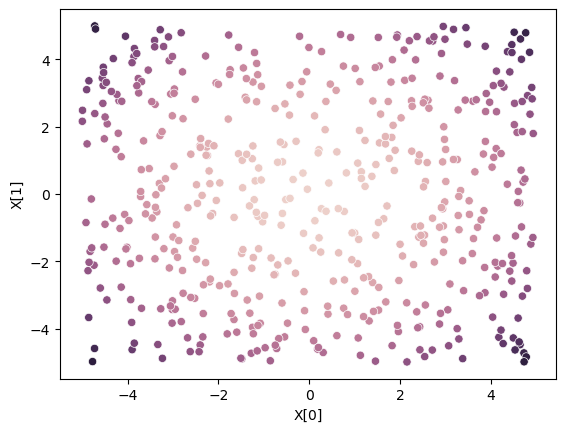

In [3]:
g = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
g.legend_.remove()
g.set(xlabel="X[0]", ylabel="X[1]")

In [7]:
def gradient_descent(
    steps: int, 
    alpha: float, 
    X: np.ndarray, 
    y: np.ndarray,
    w = None,
    eps = 1,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    
    for i in range(steps):
        
        y_pred = X.dot(w_cur)
        err = y_pred - y
        grad = 2 * X.T.dot(err) / n
        if np.sum(grad**2)**0.5 < eps:
            break
        w_cur -= alpha * grad

        w_history.append(w_cur.copy())
        err_history.append(err.mean())

    return w_cur, np.array(w_history), np.array(err_history)

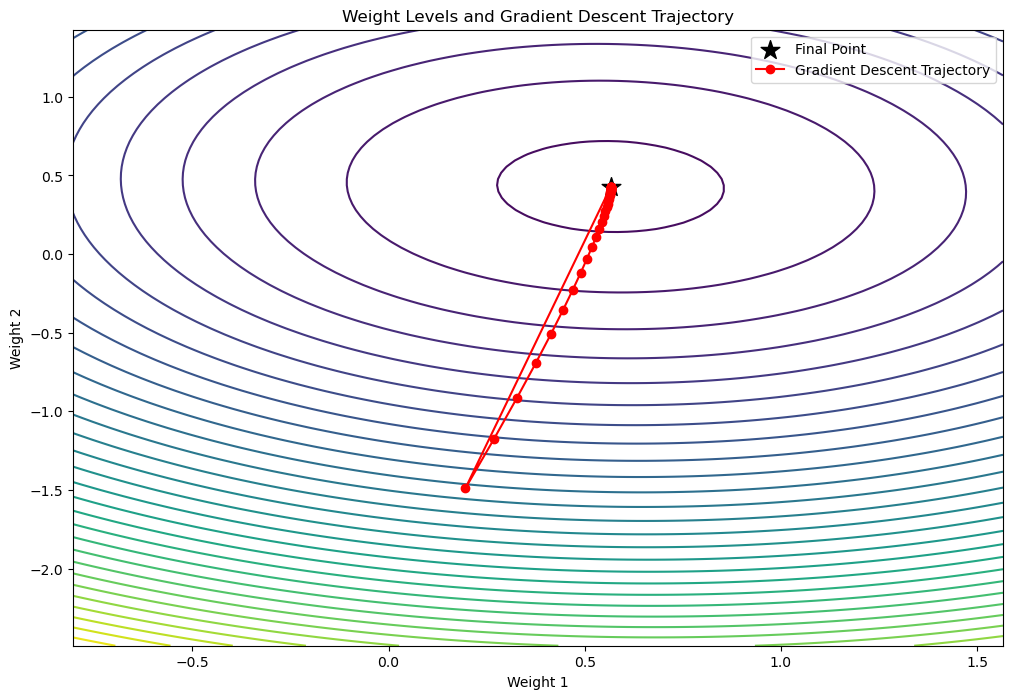

In [14]:
w_gd, w_hist_gd, w_err_gd = gradient_descent(200, 0.01, X=X, y=y, eps=0.05)

plot_weight_levels(X, y, w_hist_gd, w_opt)

## SGD

In [19]:
def generate_batch(X, y, batch_size):
    """ Генератор для получения батча из данных """
    for i in range(0, len(X), batch_size):
        yield X[i : i + batch_size], y[i : i + batch_size]

In [148]:
def stochastic_gradient_descent(
    epochs: int, 
    batch_size: int, 
    lr: float, 
    X: np.ndarray, 
    y: np.ndarray, 
    w = None,
    max_iters=1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    n_iter = 0
    for _ in range(epochs):
        p = np.random.permutation(len(X)) # случайно перемешиваем выборку
        batch_generator = generate_batch(X[p], y[p], batch_size)  # инициализируем генератор

        for X_batch, y_batch in batch_generator:  # Итерируемся по полученными батчам
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad = 2 * X_batch.T.dot(err) / n
            w_cur -= lr * grad

            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter += 1
            if n_iter == max_iters:
                 return w, np.array(w_history), np.array(err_history)

    return w, np.array(w_history), np.array(err_history)

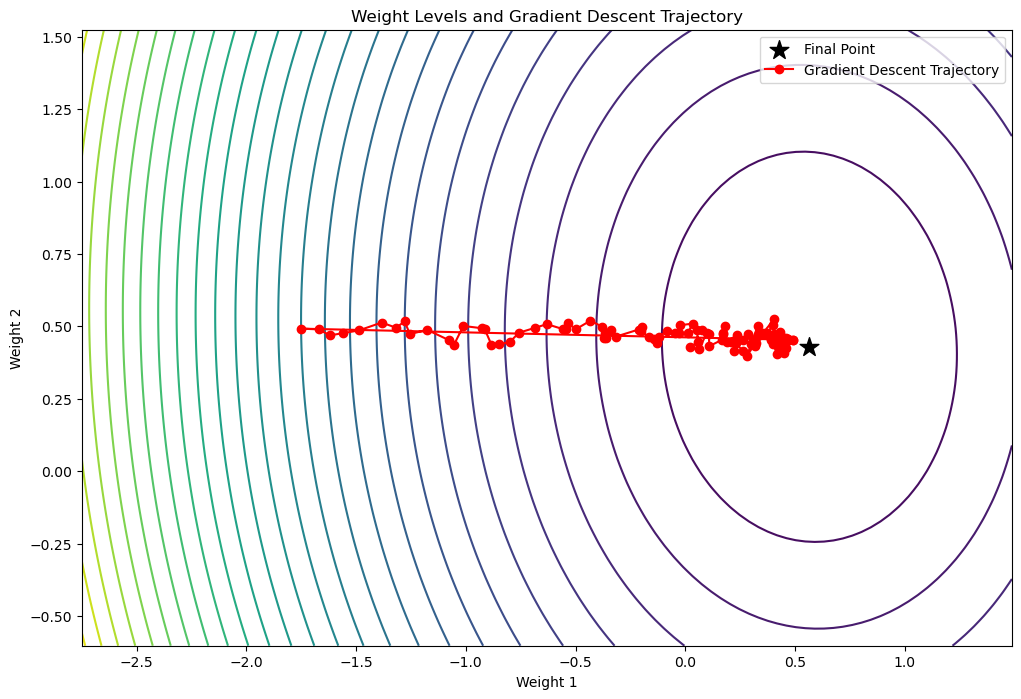

In [154]:
sgd_w, sgd_w_hist, sgd_w_err = stochastic_gradient_descent(50, 100, 0.01, X, y, max_iters=100)
plot_weight_levels(X, y, sgd_w_hist, w_opt)

## Momentum

In [41]:
def momentum(
    steps: int, 
    lr: float, 
    X: np.ndarray, 
    y: np.ndarray,
    w = None,
    eps=1,
    alpha=0.5,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)
    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    
    h = 0
    
    for _ in range(steps):
        y_pred = X.dot(w_cur)
        err = y_pred - y 
        grad = 2 * X.T.dot(err) / n
        
        h = alpha * h + lr * grad
        
        if np.sum(grad**2)**0.5 < eps:
            break

        w_cur -= h
        
        w_history.append(w_cur.copy())
        err_history.append(err.mean())
    # print(w_cur)
    return w_cur, np.array(w_history), np.array(err_history)

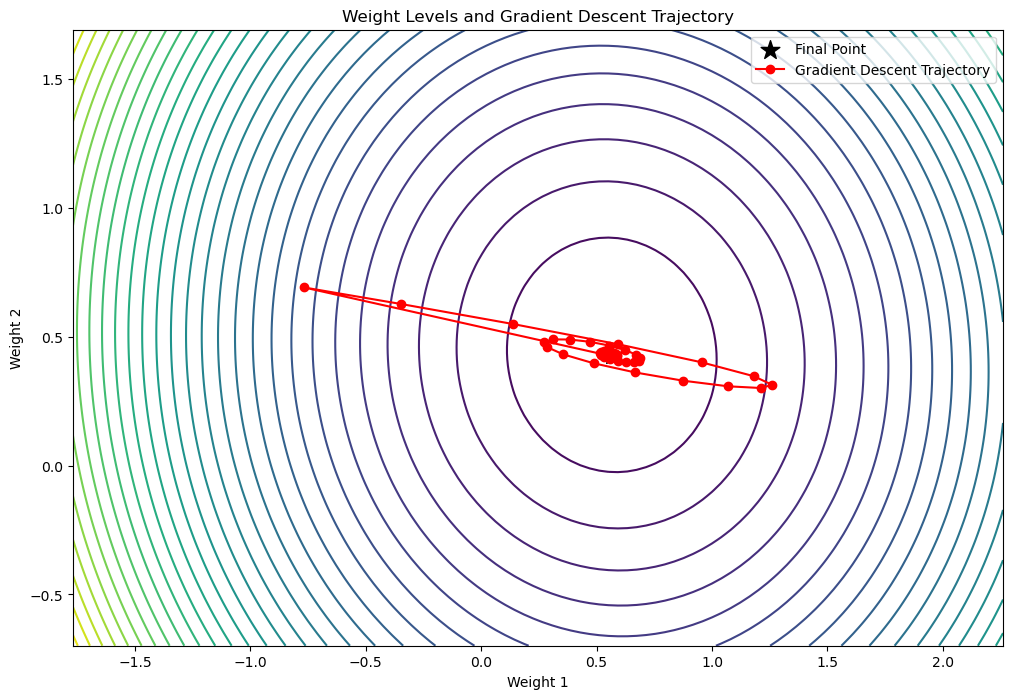

In [120]:
mom_w, mom_w_hist, mom_w_err = momentum(100, 0.01, X=X, y=y, eps=0.1, alpha=0.8)

plot_weight_levels(X, y, mom_w_hist, w_opt)

## RMSProp

In [92]:
def rmsprop(
    steps: int, 
    lr: float, 
    X: np.ndarray, 
    y: np.ndarray,
    w = None,
    eps=1,
    alpha=0.5,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m) - 3

    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    
    g = 0
    
    for _ in range(steps):
        y_pred = X.dot(w_cur)
        err = y_pred - y
        grad = 2 * X.T.dot(err) / n
        
        g = alpha * g + (1 - alpha) * grad ** 2
        
        if np.sum(grad**2)**0.5 < eps:
            break

        w_cur -= lr / (np.sqrt(g + 1e-8)) * grad
        
        w_history.append(w_cur.copy())
        err_history.append(err.mean())
    return w_cur, np.array(w_history), np.array(err_history)

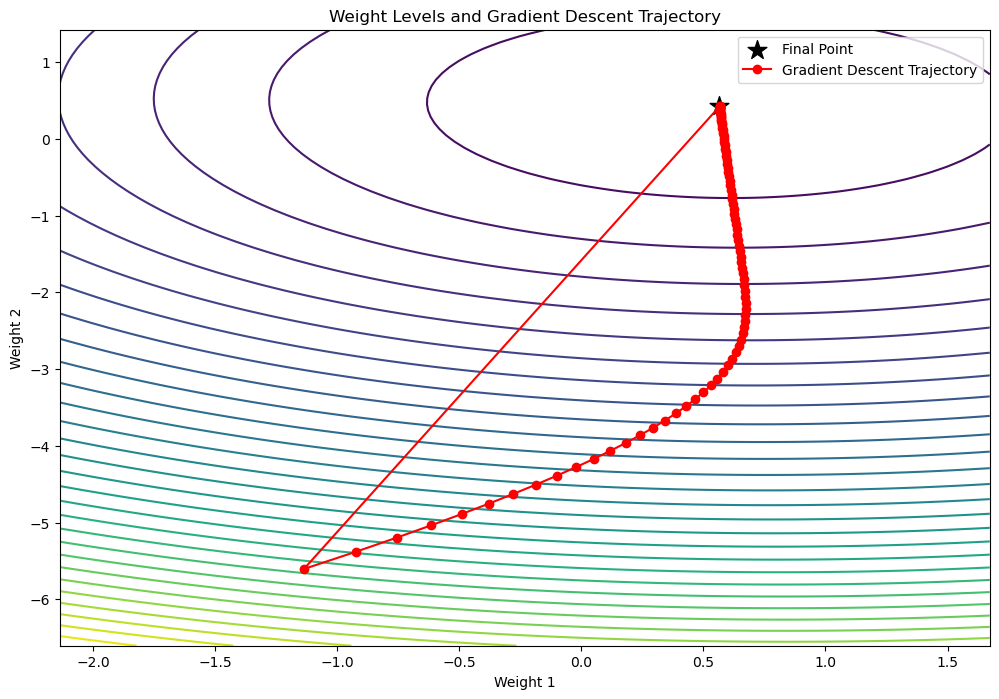

In [101]:
rmsp_w, rmsp_w_hist, rmsp_w_err = rmsprop(1000, 0.1, X=X, y=y, eps=0.1, alpha=0.9)

plot_weight_levels(X, y, rmsp_w_hist, w_opt)

## ADAM

In [121]:
def adam(
    steps: int, 
    lr: float, 
    X: np.ndarray, 
    y: np.ndarray,
    w = None,
    eps=1,
    alpha=0.5,
    beta=0.5
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    
    h = 0
    g = 0
    
    for _ in range(steps):
        
        y_pred = X.dot(w_cur)
        err = y_pred - y
        grad = 2 * X.T.dot(err) / n
        
        h = alpha * h + (1 - alpha) * grad
        g = beta * g + (1 - beta) * grad ** 2
        
        if np.sum(grad**2)**0.5 < eps:
            break
        w_cur -= lr / (np.sqrt(g + 1e-8)) * h
        
        w_history.append(w_cur.copy())
        err_history.append(err.mean())
    return w_cur, np.array(w_history), np.array(err_history)

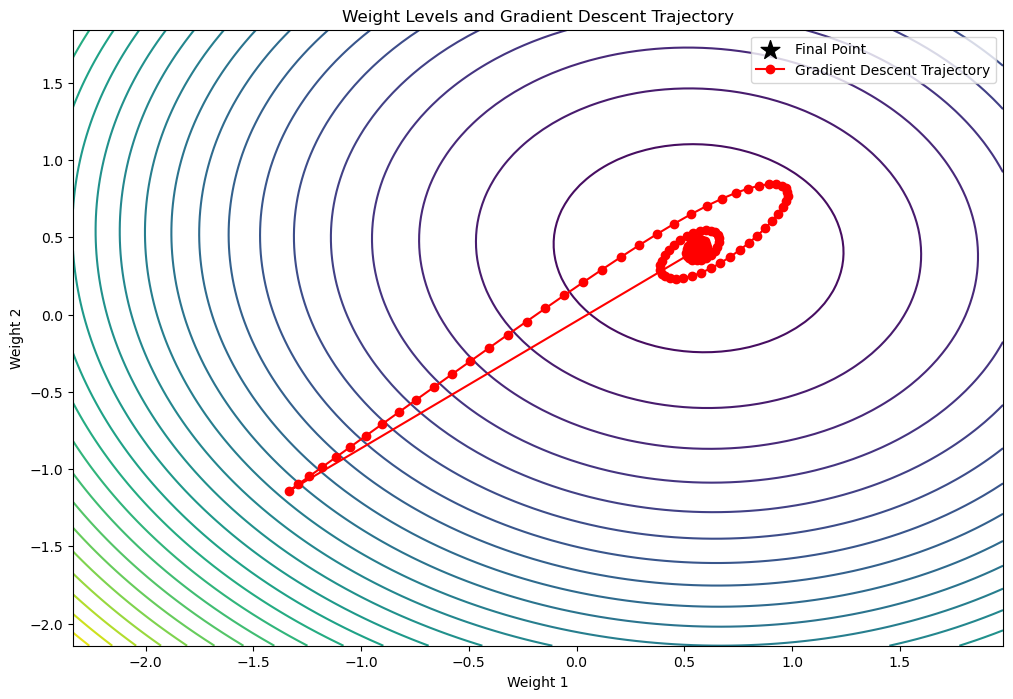

In [144]:
adam_w, adam_w_hist, adam_w_err = adam(1000, 0.1, X=X, y=y, eps=0.1, alpha=0.9, beta=0.9)

plot_weight_levels(X, y, adam_w_hist, w_opt)

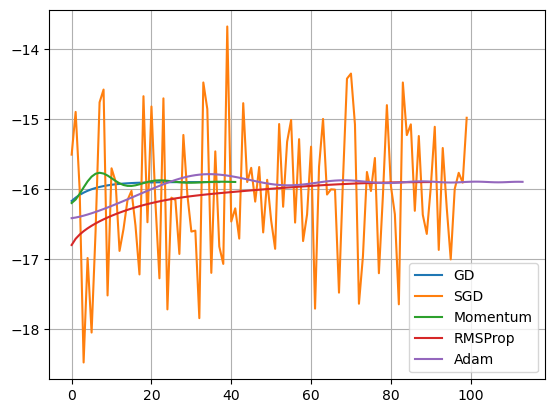

In [158]:
plt.plot(w_err_gd, label="GD")
plt.plot(sgd_w_err, label="SGD")
plt.plot(mom_w_err, label="Momentum")
plt.plot(rmsp_w_err, label="RMSProp")
plt.plot(adam_w_err, label="Adam")
plt.grid()
plt.legend()